Which product categories drive the biggest profits? Is this the same across store locations?

Can you find any seasonal trends or patterns in the sales data?

Are sales being lost with out-of-stock products at certain locations?

How much money is tied up in inventory at the toy stores? How long will it last?

# Import libraries

In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(13, 8)})

# Load data

In [2]:
inventory_df = pd.read_csv("inventory.csv")
products_df = pd.read_csv("products.csv")
sales_df = pd.read_csv("sales.csv")
stores_df = pd.read_csv("stores.csv")

# First glance

In [3]:
inventory_df.head()

Store_ID  Product_ID  Stock_On_Hand
0         1           1             27
1         1           2              0
2         1           3             32
3         1           4              6
4         1           5              0

In [4]:
products_df.head()

Product_ID      Product_Name Product_Category Product_Cost Product_Price
0           1     Action Figure             Toys       $9.99        $15.99 
1           2    Animal Figures             Toys       $9.99        $12.99 
2           3   Barrel O' Slime     Art & Crafts       $1.99         $3.99 
3           4  Chutes & Ladders            Games       $9.99        $12.99 
4           5  Classic Dominoes            Games       $7.99         $9.99

In [5]:
sales_df.head()

Sale_ID        Date  Store_ID  Product_ID  Units
0        1  2017-01-01        24           4      1
1        2  2017-01-01        28           1      1
2        3  2017-01-01         6           8      1
3        4  2017-01-01        48           7      1
4        5  2017-01-01        44          18      1

In [6]:
stores_df.head()

Store_ID                Store_Name   Store_City Store_Location  \
0         1  Maven Toys Guadalajara 1  Guadalajara    Residential   
1         2    Maven Toys Monterrey 1    Monterrey    Residential   
2         3  Maven Toys Guadalajara 2  Guadalajara     Commercial   
3         4     Maven Toys Saltillo 1     Saltillo       Downtown   
4         5       Maven Toys La Paz 1       La Paz       Downtown   

  Store_Open_Date  
0      1992-09-18  
1      1995-04-27  
2      1999-12-27  
3      2000-01-01  
4      2001-05-31

# Acquaintance and preprocessing

In [7]:
products_df['Product_Cost'] = products_df['Product_Cost'].apply(lambda value: value[1:]).astype(float)
products_df['Product_Price'] = products_df['Product_Price'].apply(lambda value: value[1:]).astype(float)
sales_df['Date'] = pd.to_datetime(sales_df['Date'], format='%Y-%m-%d')
stores_df['Store_Open_Date'] = pd.to_datetime(stores_df['Store_Open_Date'], format='%Y-%m-%d')

In [8]:
inventory_rep = ProfileReport(inventory_df)
products_rep = ProfileReport(products_df)
sales_rep = ProfileReport(sales_df)
stores_rep = ProfileReport(stores_df)

In [9]:
#inventory_rep.to_widgets()

In [10]:
#products_rep.to_widgets()

In [11]:
#sales_rep.to_widgets()

In [12]:
#stores_rep.to_widgets()

# Sales per category and store location.

## Which product categories drive the biggest profits?

In [13]:
sales_with_categories_df = pd.merge(sales_df, products_df, on='Product_ID')
category_profit_df = sales_with_categories_df.groupby('Product_Category').apply(lambda row: ((row['Product_Price'] - row['Product_Cost']) * row['Units']).sum())

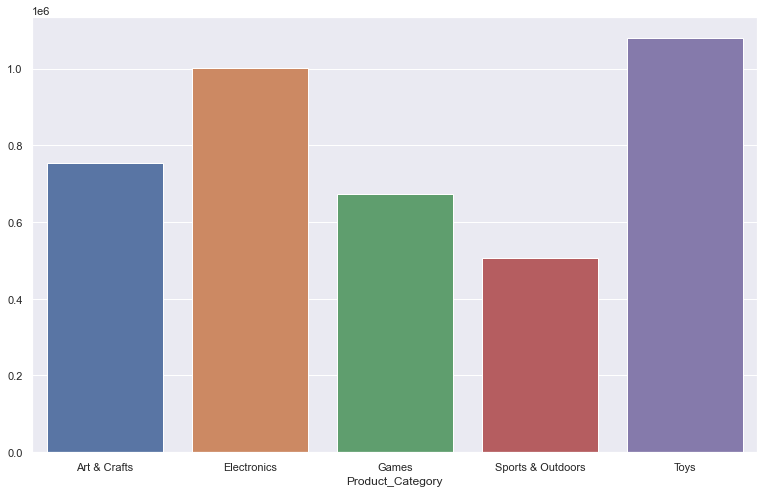

In [14]:
sns.barplot(x=category_profit_df.index, y=category_profit_df.values);

Toys and Electronics are the most profitable categories based on past sales

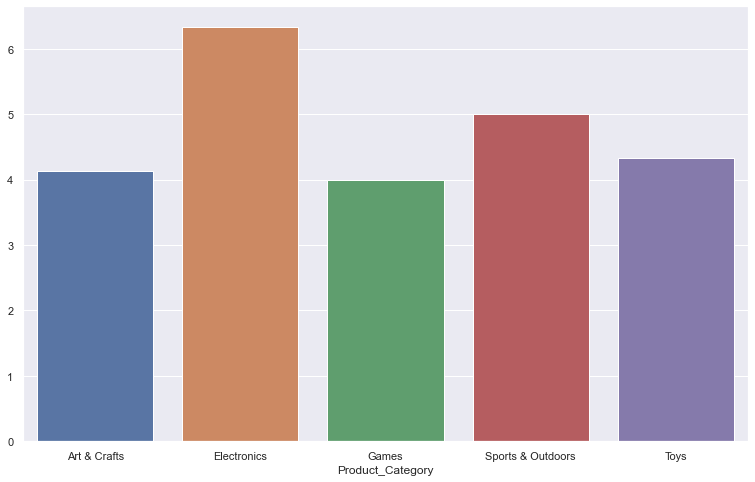

In [15]:
avg_profit_per_category = products_df.groupby('Product_Category').apply(lambda group: (group['Product_Price'] - group['Product_Cost']).mean())
sns.barplot(x=avg_profit_per_category.index, y=avg_profit_per_category.values);

Electronics is the most profitable category based on the average profit per product.

## Is this the same across store locations?

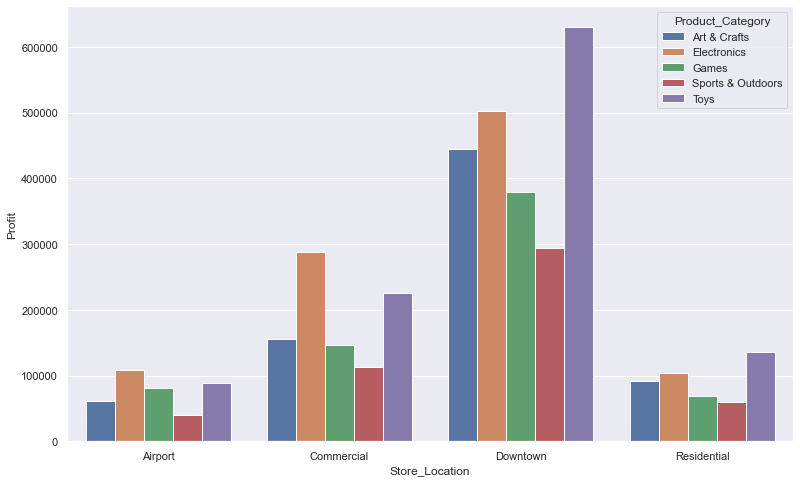

In [16]:
# raw
sales_with_categories_stores_df = pd.merge(sales_with_categories_df, stores_df, on='Store_ID')
location_category_profit_df = sales_with_categories_stores_df.groupby(['Store_Location', 'Product_Category']).apply(lambda row: ((row['Product_Price'] - row['Product_Cost']) * row['Units']).sum()).reset_index(name='Profit')
sns.barplot(data=location_category_profit_df, x='Store_Location', y='Profit', hue='Product_Category');

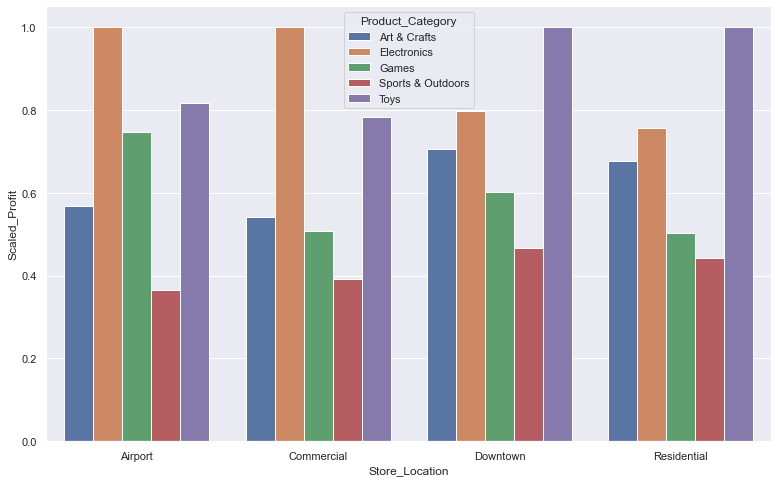

In [17]:
# scaled
max_per_location = location_category_profit_df.groupby('Store_Location')['Profit'].max()
for label, group in location_category_profit_df.groupby('Store_Location'):
    location_category_profit_df.loc[group.index, 'Scaled_Profit'] = (group['Profit'] / max_per_location[label]).values
sns.barplot(data=location_category_profit_df, x='Store_Location', y='Scaled_Profit', hue='Product_Category');

Toys and Electronics are the most profitable categories for each store location relative to location sales. Generally, 'Downtown' has the most total sales and the sale per category distribution seems to have the same among all locations.

# Seasonal trends and patterns

In [18]:
# cost *
# price *
# profit *
# units
# product id
# product category
# store id
# store city 
# store location
# store open date

## Number of Sales, Cost, Price and Profit

In [19]:
def get_daily_stats(daily_data):
    daily_sales = len(daily_data)
    daily_cost = (daily_data['Product_Cost']*daily_data['Units']).sum()
    daily_price = (daily_data['Product_Price']*daily_data['Units']).sum()
    daily_profit = daily_price - daily_cost
    return pd.Series({"Sales": daily_sales, "Cost": daily_cost, "Price": daily_price, "Profit": daily_profit})

daily_sales_stats = sales_with_categories_df.groupby('Date').apply(lambda daily_data: get_daily_stats(daily_data)).reset_index()
daily_sales_stats_ma = pd.DataFrame(data=daily_sales_stats.rolling(30, center=True).mean())
daily_sales_stats_ma['Date'] = daily_sales_stats['Date']

<AxesSubplot:xlabel='Date'>

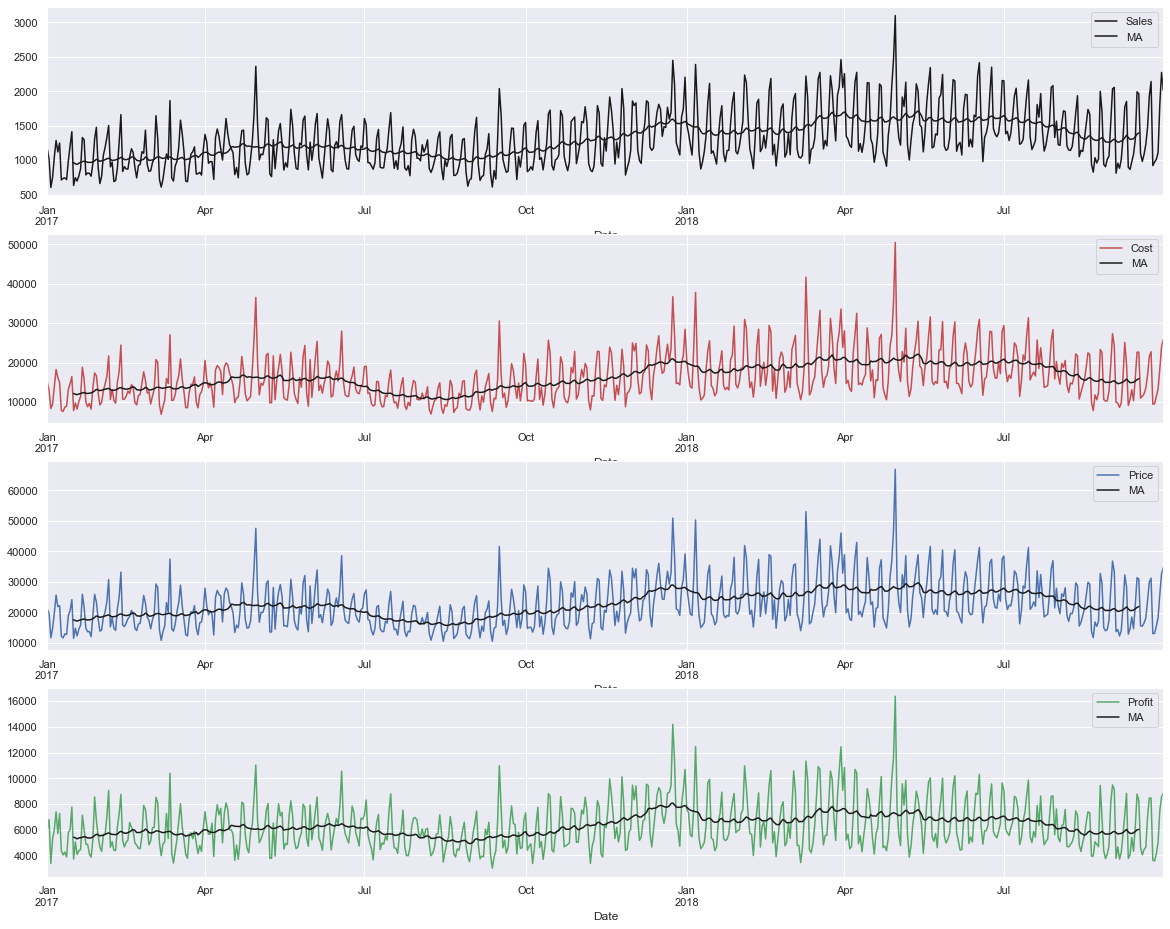

In [20]:
fig, ax = plt.subplots(4, 1, figsize=(20,16))
daily_sales_stats.plot.line(x='Date', y='Sales', ax=ax[0], c='k')
daily_sales_stats_ma.plot.line(x='Date', y='Sales', ax=ax[0], c='k', label='MA')
daily_sales_stats.plot.line(x='Date', y='Cost', ax=ax[1], c='r')
daily_sales_stats_ma.plot.line(x='Date', y='Cost', ax=ax[1], c='k', label='MA')
daily_sales_stats.plot.line(x='Date', y='Price', ax=ax[2], c='b')
daily_sales_stats_ma.plot.line(x='Date', y='Price', ax=ax[2], c='k', label='MA')
daily_sales_stats.plot.line(x='Date', y='Profit', ax=ax[3], c='g')
daily_sales_stats_ma.plot.line(x='Date', y='Profit', ax=ax[3], c='k', label='MA')

Weak positive trend with increasing variance

## Profit per Sale

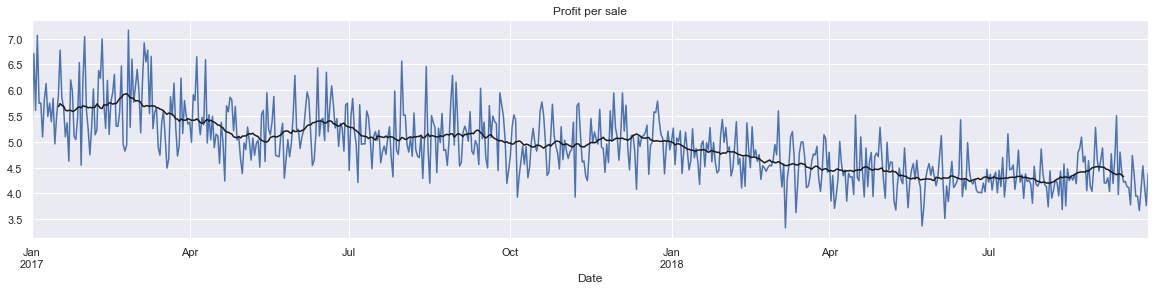

In [21]:
daily_profit_per_sale = pd.Series(index=daily_sales_stats['Date'], data=(daily_sales_stats['Profit']/daily_sales_stats['Sales']).values)
daily_profit_per_sale_ma = daily_profit_per_sale.rolling(30, center=True).mean()
fig, ax = plt.subplots(figsize=(20, 4))
daily_profit_per_sale.plot(ax=ax)
daily_profit_per_sale_ma.plot(ax=ax, c='k', label='MA');
ax.set_title('Profit per sale')
plt.show()

Negative trend of profit per sale. Sales in 2017 were more profitable than sales in 2018. Considering the increasing number of sales (previous plot), and the increasing profit, we can hypothesize that in 2018 there are more sales but less profitable.

## Profit per category

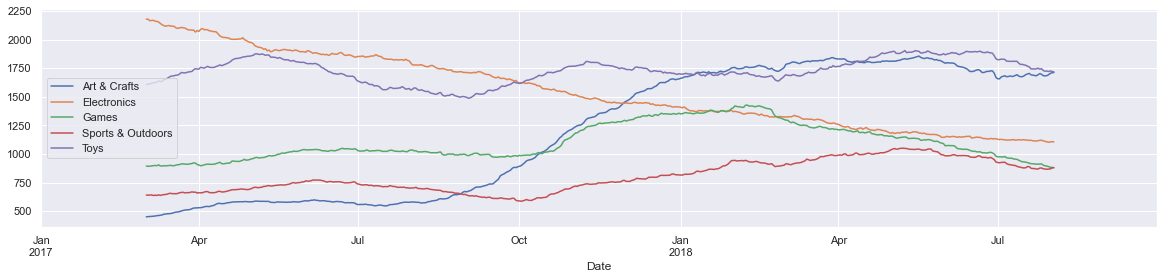

In [22]:
daily_profit_per_category = sales_with_categories_df.groupby(['Date', 'Product_Category']).apply(lambda row: ((row['Product_Price'] - row['Product_Cost']) * row['Units']).sum()).to_frame(name='Profit').reset_index()
fig, ax = plt.subplots(figsize=(20,4))
for label, group in daily_profit_per_category.groupby('Product_Category'):
    group = group.copy()
    group['Profit'] = group['Profit'].rolling(120, center=True).mean() # big window to create smooth lines
    group.plot(x='Date', y='Profit', ax=ax, label=label)

Profit from Electronics decreases over time, whereas Art & Crafts present a positive trend. Generally, Toys provide a great and stable profit the whole period.

## Profit per Category Correlation

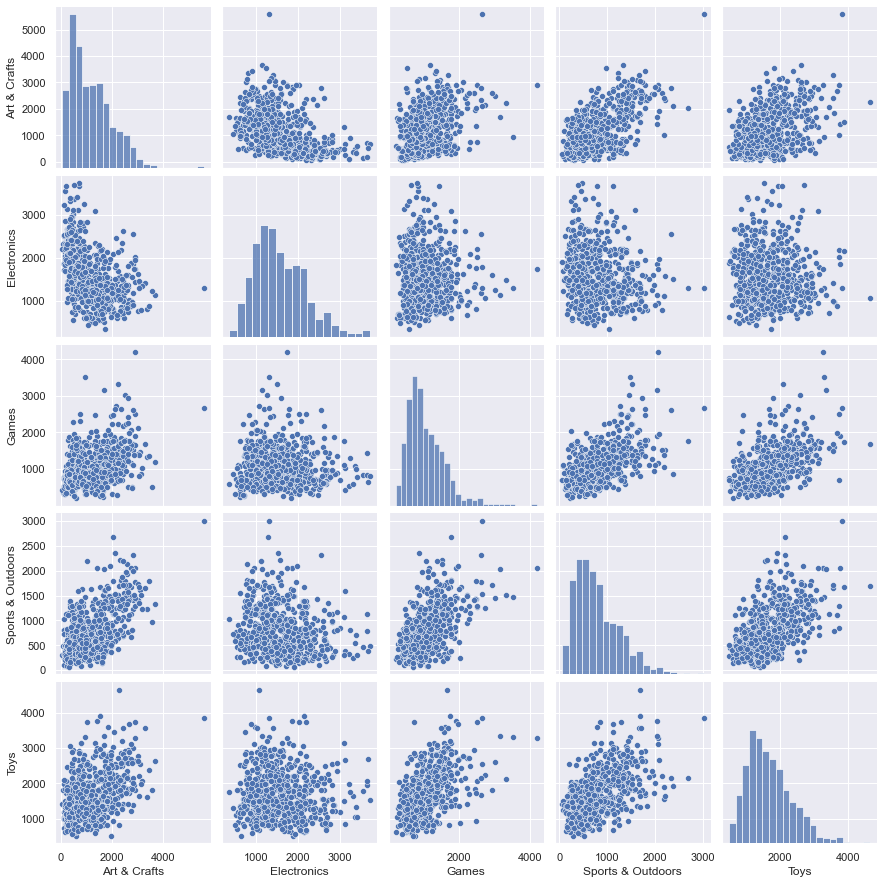

In [23]:
sns.pairplot(daily_profit_per_category.set_index(['Product_Category','Date']).unstack(['Product_Category']).droplevel(0,axis=1));

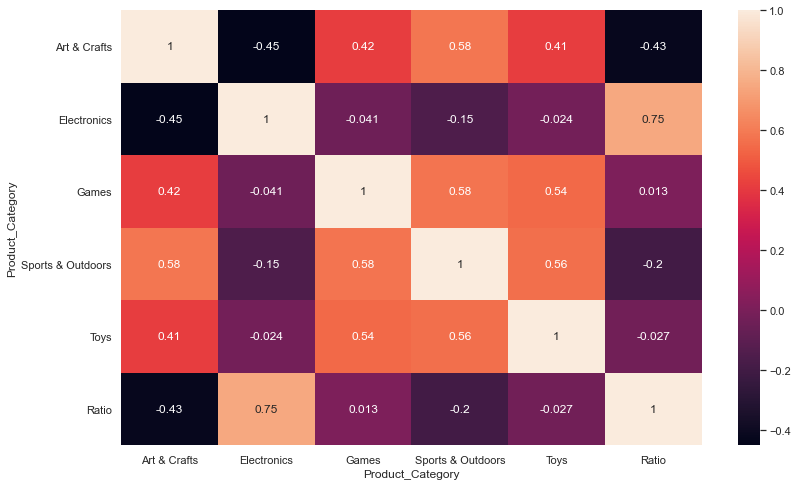

In [24]:
daily_profits_corr = pd.pivot(data=daily_profit_per_category,index='Date', columns='Product_Category', values='Profit')
daily_profits_corr['Ratio'] = daily_profit_per_sale
sns.heatmap(daily_profits_corr.corr(), annot=True);

Art & Craft, Games, Sports & Outdoors and Toys profits present a positive correlation with medium magnitude. Art & Crafts and Electronics present a negative correlation. The pairplots above show that there is not strong linear relationship between the categories, so the spearman correlation is not much trustworthy.

## Statistically significant products 
Products that have had any statistically significant attribute over time.

In [25]:
index = pd.MultiIndex.from_product([pd.Series(sales_df['Date'].unique(), name='Date'), products_df['Product_ID']])
daily_per_product = pd.DataFrame(index=index).reset_index()
daily_per_product = daily_per_product.merge(sales_df.groupby(['Date', 'Product_ID']).agg(Units=('Units', 'sum'), Sales=('Sale_ID', 'count')).reset_index(), on=['Date', 'Product_ID'], how='left')
daily_per_product.fillna(0, inplace=True)

In [26]:
monthly_per_product_stats = daily_per_product.set_index('Date').groupby([pd.Grouper(freq='1M'), 'Product_ID']).agg(Sales=('Sales', 'sum'), Units=('Units', 'sum')).reset_index().sort_values(by=['Date', 'Product_ID'])
temp = monthly_per_product_stats.merge(products_df, on='Product_ID').sort_values(by=['Date', 'Product_ID']).reset_index(drop=True)
monthly_per_product_stats['Total_Profit'] = (temp['Product_Price'] - temp['Product_Cost']) * temp['Units']
monthly_per_product_stats['Profit_per_Sale'] = monthly_per_product_stats['Total_Profit'] / monthly_per_product_stats['Sales']
monthly_per_product_stats['Profit_per_Sale'].replace({np.inf: 0, np.nan: 0}, inplace=True)

In [27]:
# The main purpose is to detect extreme values in the time series that have obeserved.
# Still, the condition "normal distribution or n>30" is fulfilled due to monthly summation, i.e. 30 days.
# Should I use average instead of sum? Nevertheless, the results suffice for my goals.
def plot_significant(df, per, target):
    fig, ax = plt.subplots(figsize=(26,8))
    std = df[target].std()
    m = df[target].mean()
    non_sign_idx = []
    stat_sign_idx = []
    for label, group in df.groupby([per]):
        if ((group[target] - m)/std  > 1.645).any(): # a=0.05 upper tailed
            sns.lineplot(x='Date', y=target, data=group, ax=ax, label=label)
            stat_sign_idx.append(label)
        else:
            non_sign_idx.append(label)
    non_sign_df = df.loc[df[per].isin(non_sign_idx)]
    sns.lineplot(x='Date', y=target, data=non_sign_df, ci=99, ax=ax, label='non-significant, ci=99', color='k')
    ax.legend(loc=1)
    ax.set_title(f"Statistically significant products, target: {target}", fontsize=16)
    
    stat_sign_df = products_df.loc[products_df[per].isin(stat_sign_idx)]
    return stat_sign_df

def plot_significant_per_id(target):
    return plot_significant(monthly_per_product_stats, 'Product_ID', target)

Product_ID     Product_Name   Product_Category  Product_Cost  \
2            3  Barrel O' Slime       Art & Crafts          1.99   
5            6        Colorbuds        Electronics          6.99   
7            8    Deck Of Cards              Games          3.99   
18          19       Magic Sand       Art & Crafts         13.99   
24          25      PlayDoh Can       Art & Crafts          1.99   
30          31     Splash Balls  Sports & Outdoors          7.99   

    Product_Price  
2            3.99  
5           14.99  
7            6.99  
18          15.99  
24           2.99  
30           8.99

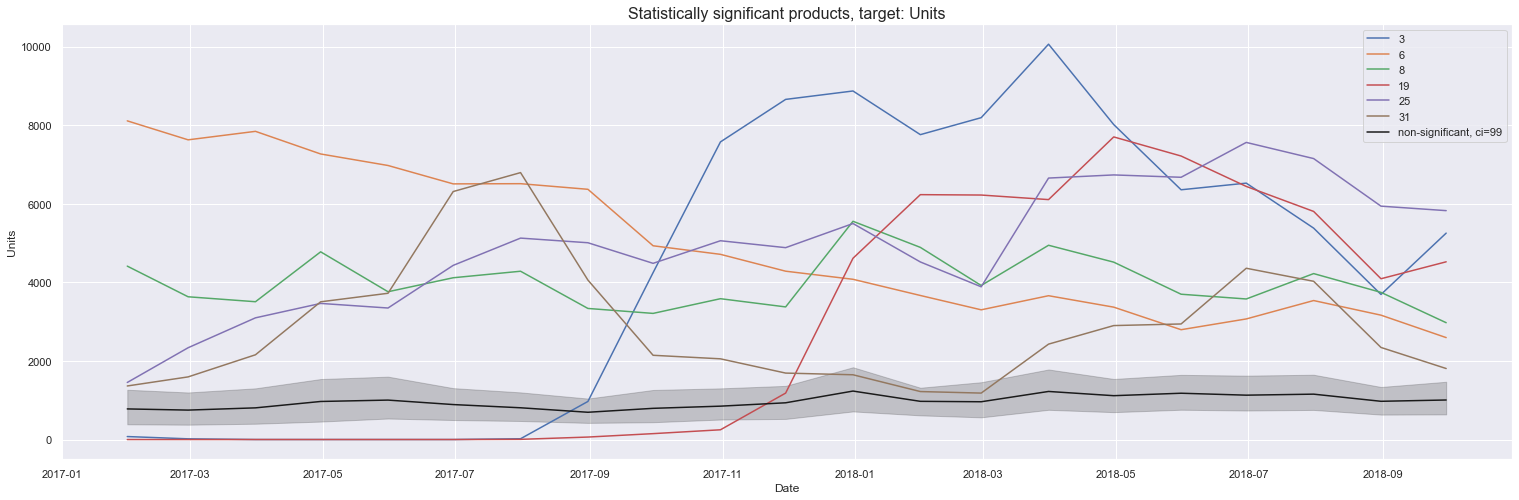

In [28]:
temp = plot_significant_per_id('Units')
unit_set = set(temp['Product_ID'].astype(str))
temp

Product_ID     Product_Name   Product_Category  Product_Cost  \
0            1    Action Figure               Toys          9.99   
2            3  Barrel O' Slime       Art & Crafts          1.99   
5            6        Colorbuds        Electronics          6.99   
7            8    Deck Of Cards              Games          3.99   
17          18      Lego Bricks               Toys         34.99   
18          19       Magic Sand       Art & Crafts         13.99   
24          25      PlayDoh Can       Art & Crafts          1.99   
29          30     Rubik's Cube              Games         17.99   
30          31     Splash Balls  Sports & Outdoors          7.99   

    Product_Price  
0           15.99  
2            3.99  
5           14.99  
7            6.99  
17          39.99  
18          15.99  
24           2.99  
29          19.99  
30           8.99

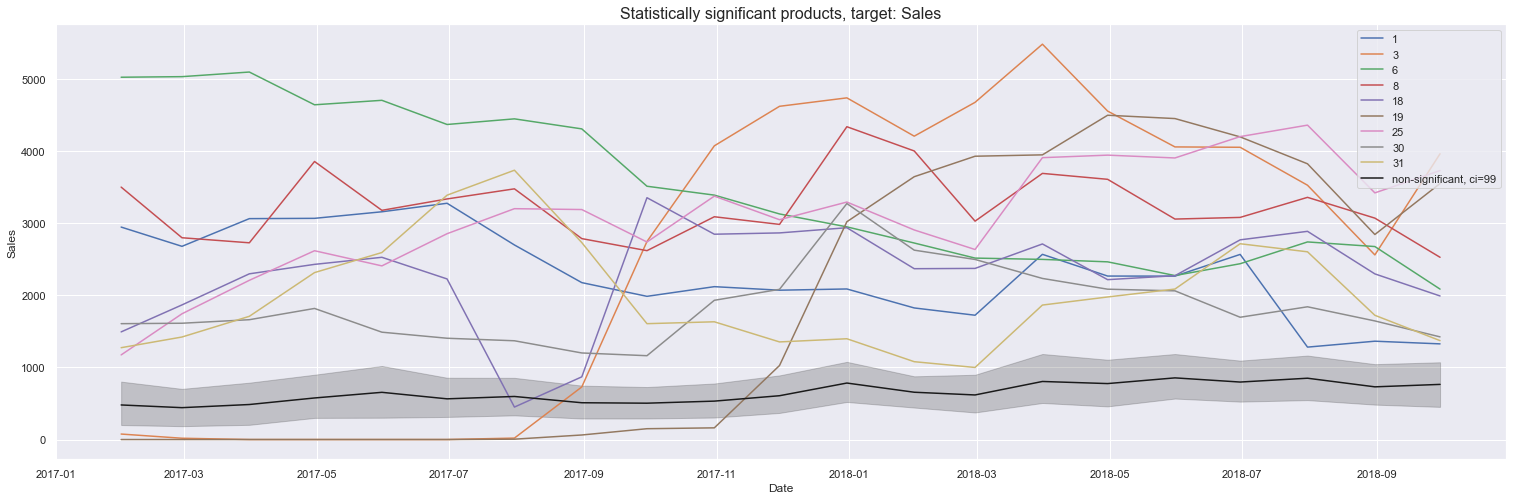

In [29]:
temp = plot_significant_per_id('Sales')
sales_set = set(temp['Product_ID'].astype(str))
temp

Product_ID     Product_Name Product_Category  Product_Cost  Product_Price
0            1    Action Figure             Toys          9.99          15.99
2            3  Barrel O' Slime     Art & Crafts          1.99           3.99
5            6        Colorbuds      Electronics          6.99          14.99
17          18      Lego Bricks             Toys         34.99          39.99
27          28         Playfoam     Art & Crafts          3.99          10.99

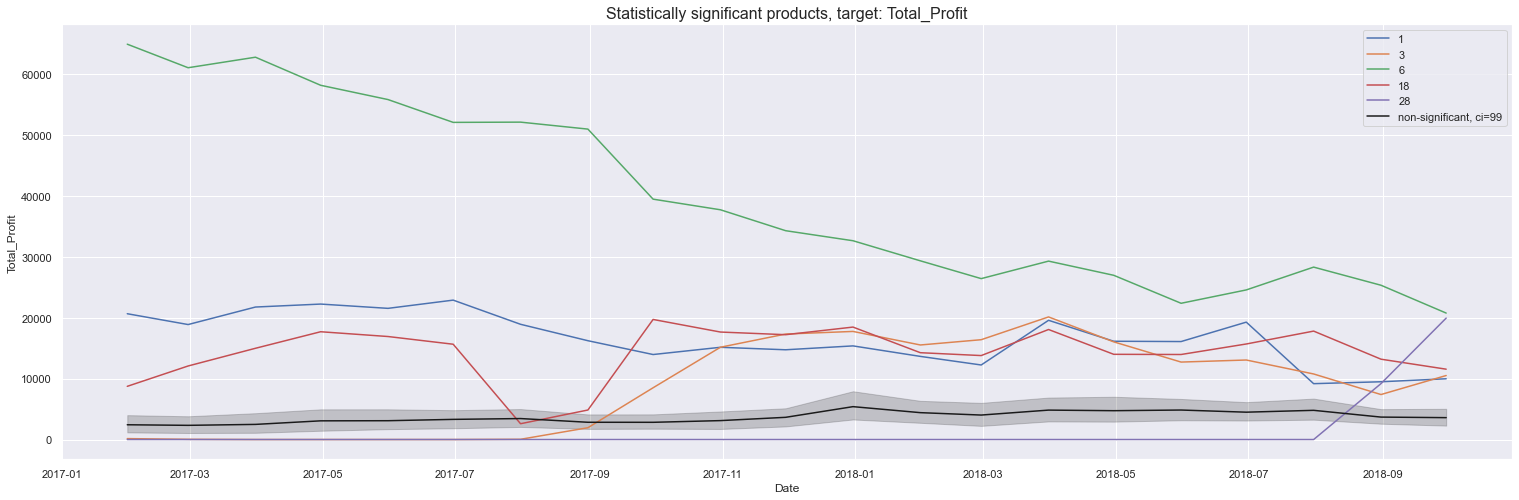

In [30]:
temp = plot_significant_per_id('Total_Profit')
profit_set = set(temp['Product_ID'].astype(str))
temp

Product_ID          Product_Name   Product_Category  Product_Cost  \
5            6             Colorbuds        Electronics          6.99   
10          11         Etch A Sketch       Art & Crafts         10.99   
19          20  Mini Basketball Hoop  Sports & Outdoors          8.99   
21          22              Monopoly              Games         13.99   
27          28              Playfoam       Art & Crafts          3.99   
28          29            Plush Pony               Toys          8.99   

    Product_Price  
5           14.99  
10          20.99  
19          24.99  
21          19.99  
27          10.99  
28          19.99

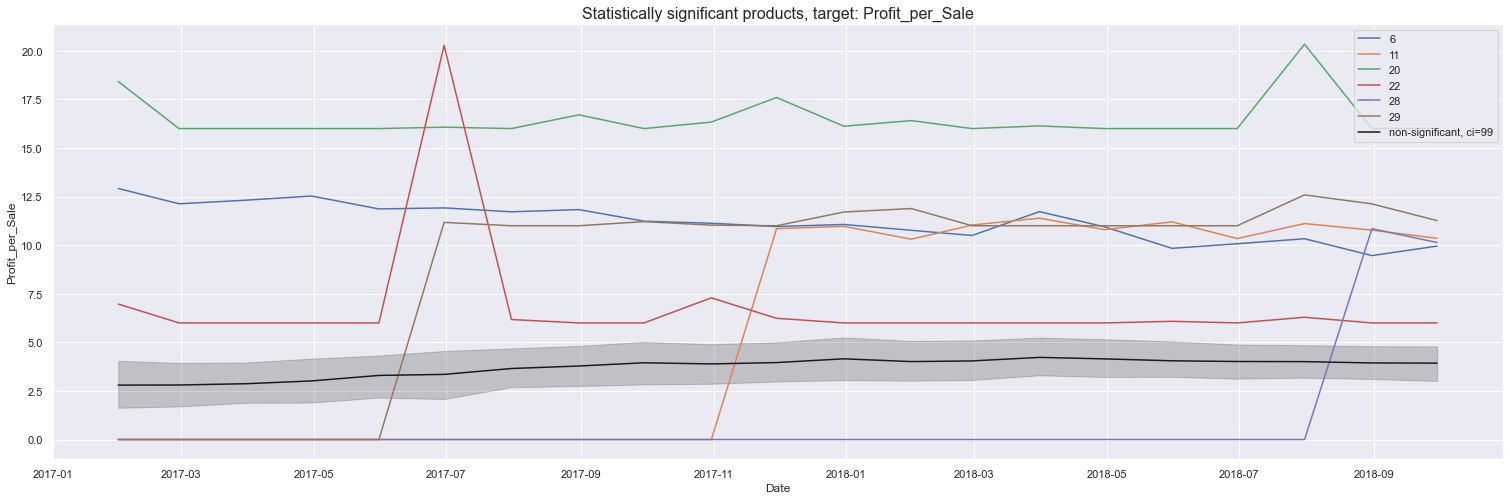

In [31]:
temp = plot_significant_per_id('Profit_per_Sale')
ratio_set = set(temp['Product_ID'].astype(str))
temp

In [32]:
# Code from Vinci's answer https://stackoverflow.com/questions/42855256/python-venn-diagram-how-to-show-the-diagram-contents
import math, itertools
from matplotlib_venn import venn2, venn3

# Generate list index for itertools combinations
def gen_index(n):
    x = -1
    while True:       
        while True:
            x = x + 1
            if bin(x).count('1') == n:
                break
        yield x

# Generate all combinations of intersections
def make_intersections(sets):
    l = [None] * 2**len(sets)
    for i in range(1, len(sets) + 1):
        ind = gen_index(i)
        for subset in itertools.combinations(sets, i):
            inter = set.intersection(*subset)
            l[next(ind)] = inter
    return l

# Get weird reversed binary string id for venn
def number2venn_id(x, n_fill):
    id = bin(x)[2:].zfill(n_fill)
    id = id[::-1]
    return id

# Iterate over all combinations and remove duplicates from intersections with
# more sets
def sets2dict(sets):
    l = make_intersections(sets)
    d = {}
    for i in range(1, len(l)):
        d[number2venn_id(i, len(sets))] = l[i]
        for j in range(1, len(l)):
            if bin(j).count('1') < bin(i).count('1'):
                l[j] = l[j] - l[i]
                d[number2venn_id(j, len(sets))] = l[j] - l[i]
    return d

def plot_venn(sets, labels):
    d = sets2dict(sets)
    h = venn3(sets, labels)
    for k, v in d.items():
        l = h.get_label_by_id(k)
        if l:
            l.set_fontsize(12)
            l.set_text('\n'.join(sorted(v)))


The venn diagrams below show the sets of the statistically significant products for each target, and their logical relation.

c:\Users\geomimo\anaconda3\envs\kagglenb\lib\site-packages\matplotlib_venn\_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


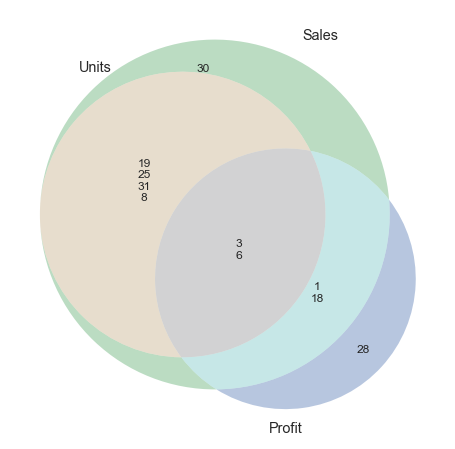

In [33]:
sets = [unit_set, sales_set, profit_set]
labels = ('Units', 'Sales', 'Profit')
plot_venn(sets, labels)

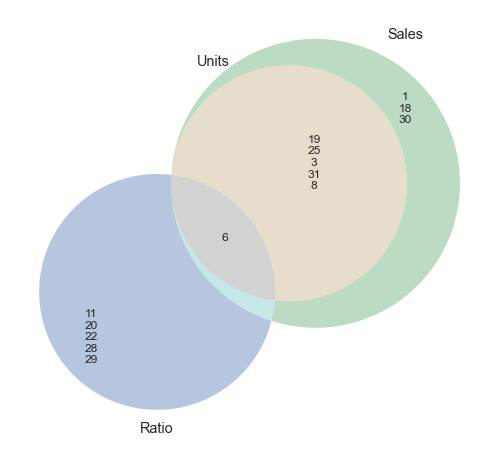

In [34]:
# breaks with 4 sets together, probably because of lack of overlays
sets = [unit_set, sales_set, ratio_set]
labels = ('Units', 'Sales', 'Ratio')
plot_venn(sets, labels)

## Statistically significant categories 
Categories that have had any statistically significant attribute over time.

In [35]:
index = pd.MultiIndex.from_product([pd.Series(sales_df['Date'].unique(), name='Date'), pd.Series(products_df['Product_Category'].unique(), name='Product_Category')])
daily_per_category = pd.DataFrame(index=index).reset_index()
daily_per_category = daily_per_category.merge(sales_with_categories_df.groupby(['Date', 'Product_Category']).agg(Units=('Units', 'sum'), Sales=('Sale_ID', 'count')).reset_index(), on=['Date', 'Product_Category'], how='left')
daily_per_category.fillna(0, inplace=True)


In [36]:
monthly_per_category_stats = daily_per_category.set_index('Date').groupby([pd.Grouper(freq='1M'), 'Product_Category']).agg(Sales=('Sales', 'sum'), Units=('Units', 'sum')).reset_index().sort_values(by=['Date', 'Product_Category'])
temp = monthly_per_category_stats.merge(products_df, on='Product_Category').sort_values(by=['Date', 'Product_Category']).reset_index(drop=True)
monthly_per_category_stats['Total_Profit'] = (temp['Product_Price'] - temp['Product_Cost']) * temp['Units']
monthly_per_category_stats['Profit_per_Sale'] = monthly_per_category_stats['Total_Profit'] / monthly_per_category_stats['Sales']
monthly_per_category_stats['Profit_per_Sale'].replace({np.inf: 0, np.nan: 0}, inplace=True)

In [37]:
def plot_significant_per_category(target):
    return plot_significant(monthly_per_category_stats, 'Product_Category', target)

Product_ID     Product_Name Product_Category  Product_Cost  Product_Price
2            3  Barrel O' Slime     Art & Crafts          1.99           3.99
10          11    Etch A Sketch     Art & Crafts         10.99          20.99
16          17  Kids Makeup Kit     Art & Crafts         13.99          19.99
18          19       Magic Sand     Art & Crafts         13.99          15.99
24          25      PlayDoh Can     Art & Crafts          1.99           2.99
25          26  PlayDoh Playset     Art & Crafts         20.99          24.99
26          27  PlayDoh Toolkit     Art & Crafts          3.99           4.99
27          28         Playfoam     Art & Crafts          3.99          10.99

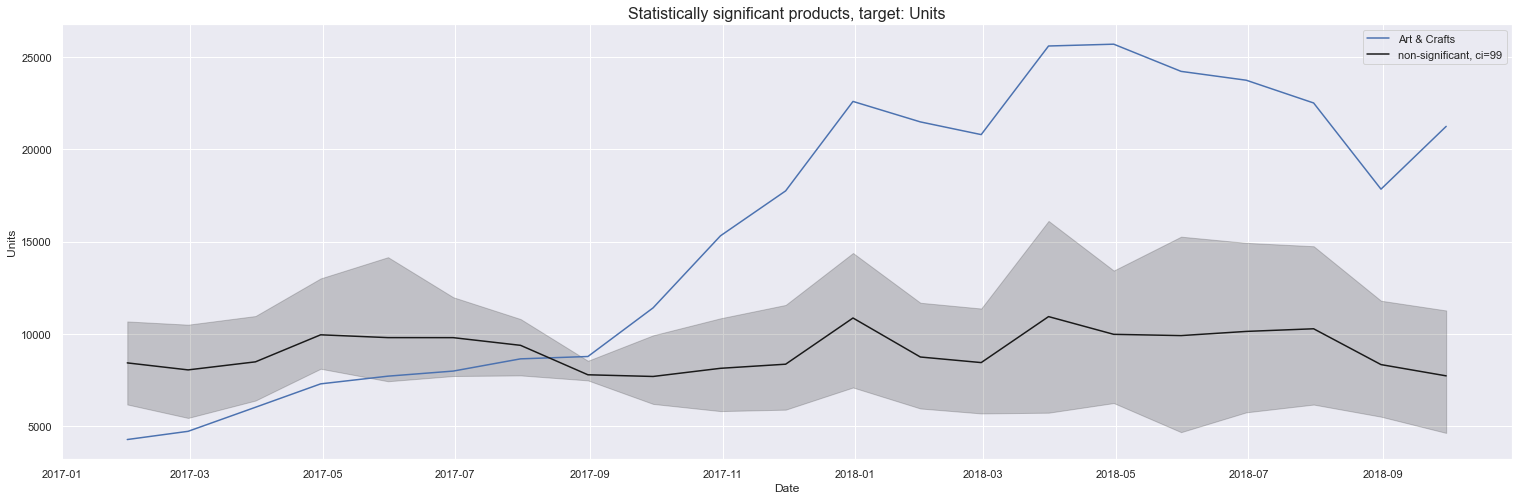

In [38]:
temp = plot_significant_per_category('Units')
unit_set = set(temp['Product_Category'].unique())
temp

Product_ID       Product_Name Product_Category  Product_Cost  \
0            1      Action Figure             Toys          9.99   
1            2     Animal Figures             Toys          9.99   
2            3    Barrel O' Slime     Art & Crafts          1.99   
8            9           Dino Egg             Toys          9.99   
9           10   Dinosaur Figures             Toys         10.99   
10          11      Etch A Sketch     Art & Crafts         10.99   
14          15  Hot Wheels 5-Pack             Toys          3.99   
16          17    Kids Makeup Kit     Art & Crafts         13.99   
17          18        Lego Bricks             Toys         34.99   
18          19         Magic Sand     Art & Crafts         13.99   
22          23     Mr. Potatohead             Toys          4.99   
24          25        PlayDoh Can     Art & Crafts          1.99   
25          26    PlayDoh Playset     Art & Crafts         20.99   
26          27    PlayDoh Toolkit     Art & Crafts          3.99   
27          28           Playfoam     Art & Crafts          3.99   
28          29         Plush Pony             Toys          8.99   
32          33         Teddy Bear             Toys         10.99   

    Product_Price  
0           15.99  
1           12.99  
2            3.99  
8           10.99  
9           14.99  
10          20.99  
14           5.99  
16          19.99  
17          39.99  
18          15.99  
22           9.99  
24           2.99  
25          24.99  
26           4.99  
27          10.99  
28          19.99  
32          12.99

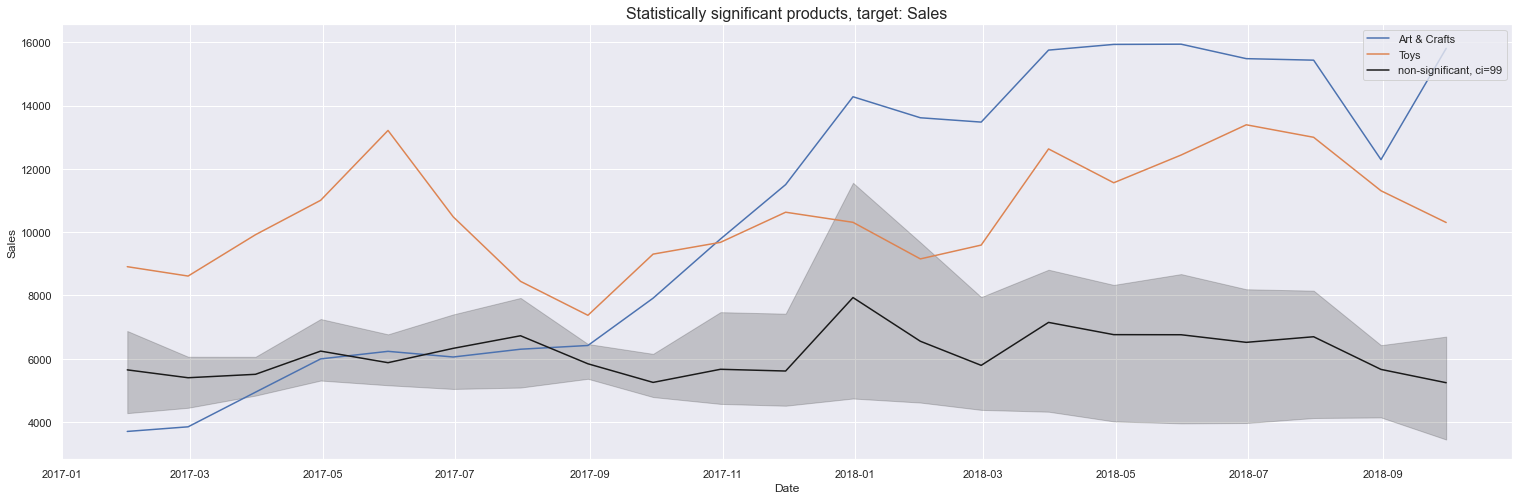

In [39]:
temp = plot_significant_per_category('Sales')
sales_set = set(temp['Product_Category'].unique())
temp

Product_ID           Product_Name   Product_Category  Product_Cost  \
5            6              Colorbuds        Electronics          6.99   
6            7               Dart Gun  Sports & Outdoors         11.99   
11          12     Foam Disk Launcher  Sports & Outdoors          8.99   
12          13       Gamer Headphones        Electronics         14.99   
19          20   Mini Basketball Hoop  Sports & Outdoors          8.99   
20          21     Mini Ping Pong Set  Sports & Outdoors          6.99   
23          24               Nerf Gun  Sports & Outdoors         14.99   
30          31           Splash Balls  Sports & Outdoors          7.99   
31          32  Supersoaker Water Gun  Sports & Outdoors         11.99   
33          34              Toy Robot        Electronics         20.99   

    Product_Price  
5           14.99  
6           15.99  
11          11.99  
12          20.99  
19          24.99  
20           9.99  
23          19.99  
30           8.99  
31          14.99  
33          25.99

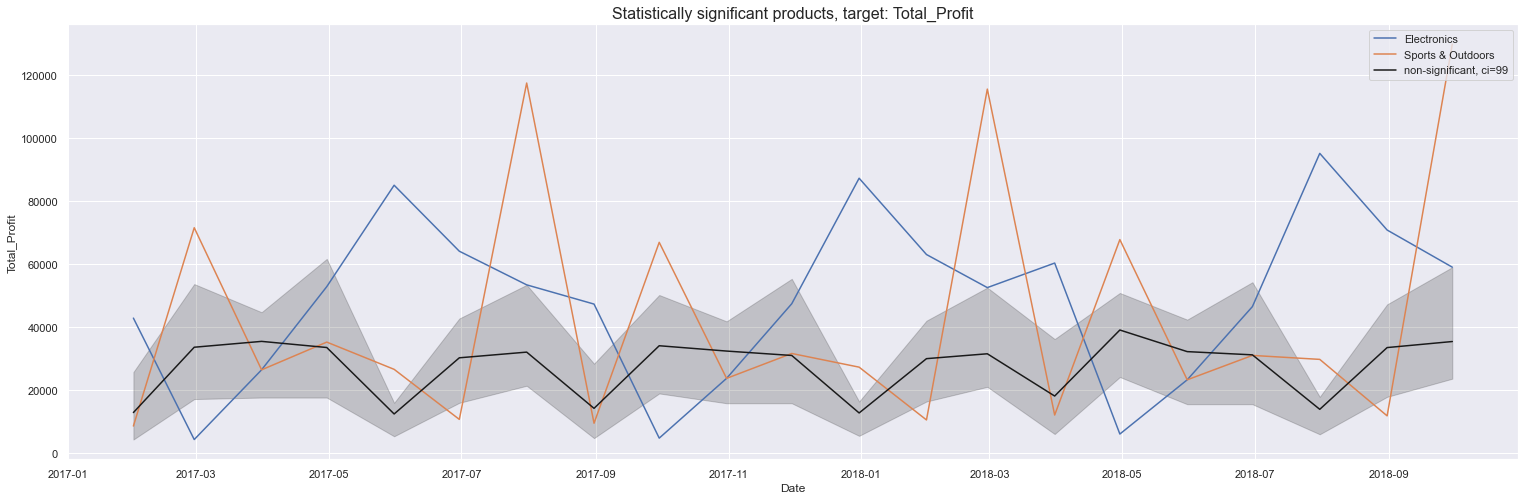

In [40]:
temp = plot_significant_per_category('Total_Profit')
profit_set = set(temp['Product_Category'].unique())
temp

Product_ID           Product_Name   Product_Category  Product_Cost  \
5            6              Colorbuds        Electronics          6.99   
6            7               Dart Gun  Sports & Outdoors         11.99   
11          12     Foam Disk Launcher  Sports & Outdoors          8.99   
12          13       Gamer Headphones        Electronics         14.99   
19          20   Mini Basketball Hoop  Sports & Outdoors          8.99   
20          21     Mini Ping Pong Set  Sports & Outdoors          6.99   
23          24               Nerf Gun  Sports & Outdoors         14.99   
30          31           Splash Balls  Sports & Outdoors          7.99   
31          32  Supersoaker Water Gun  Sports & Outdoors         11.99   
33          34              Toy Robot        Electronics         20.99   

    Product_Price  
5           14.99  
6           15.99  
11          11.99  
12          20.99  
19          24.99  
20           9.99  
23          19.99  
30           8.99  
31          14.99  
33          25.99

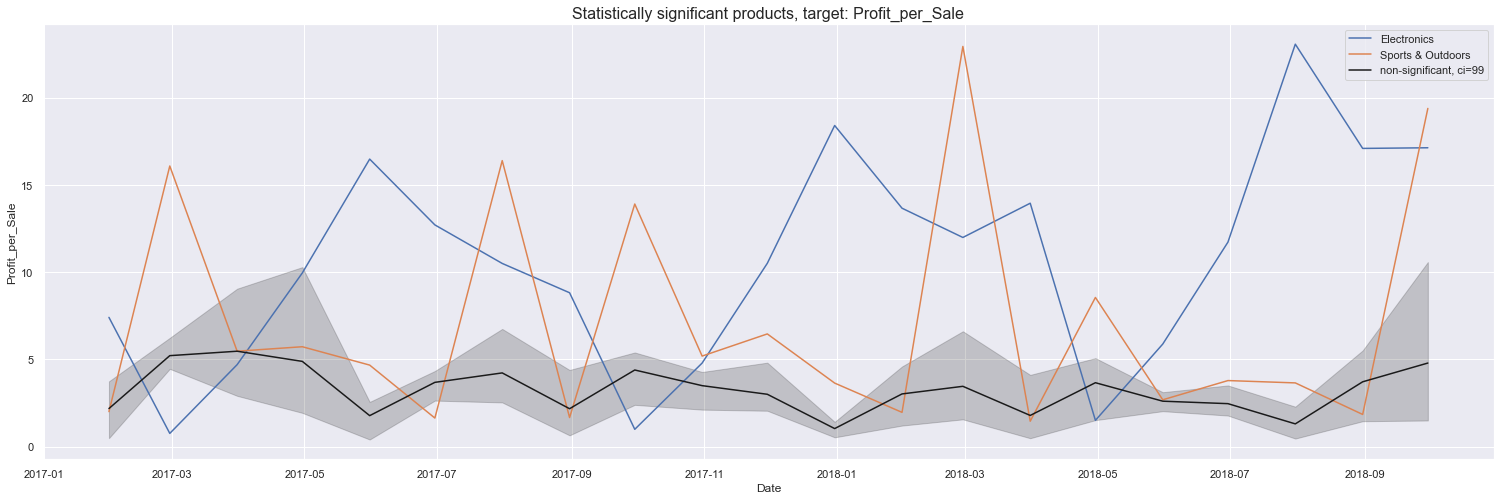

In [41]:
temp = plot_significant_per_category('Profit_per_Sale')
ratio_set = set(temp['Product_Category'].unique())
temp

The venn diagrams below show the sets of the statistically significant categories for each target, and their logical relation.

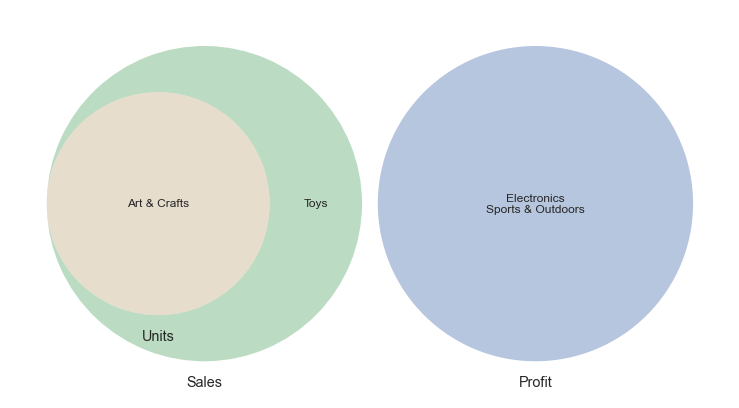

In [42]:
sets = [unit_set, sales_set, profit_set]
labels = ('Units', 'Sales', 'Profit')
plot_venn(sets, labels)

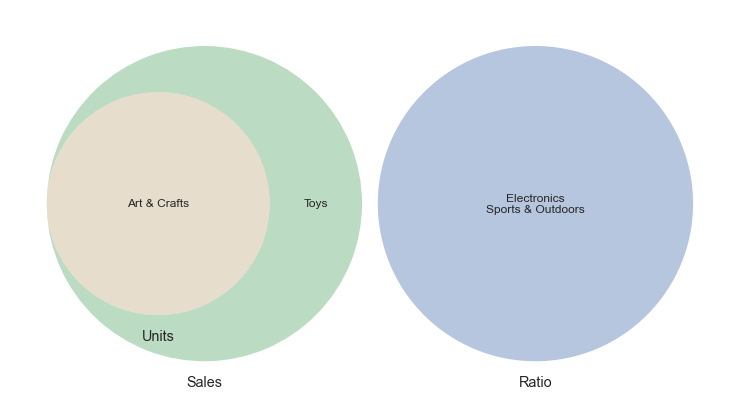

In [43]:
sets = [unit_set, sales_set, ratio_set]
labels = ('Units', 'Sales', 'Ratio')
plot_venn(sets, labels)

## Time Series Analysis

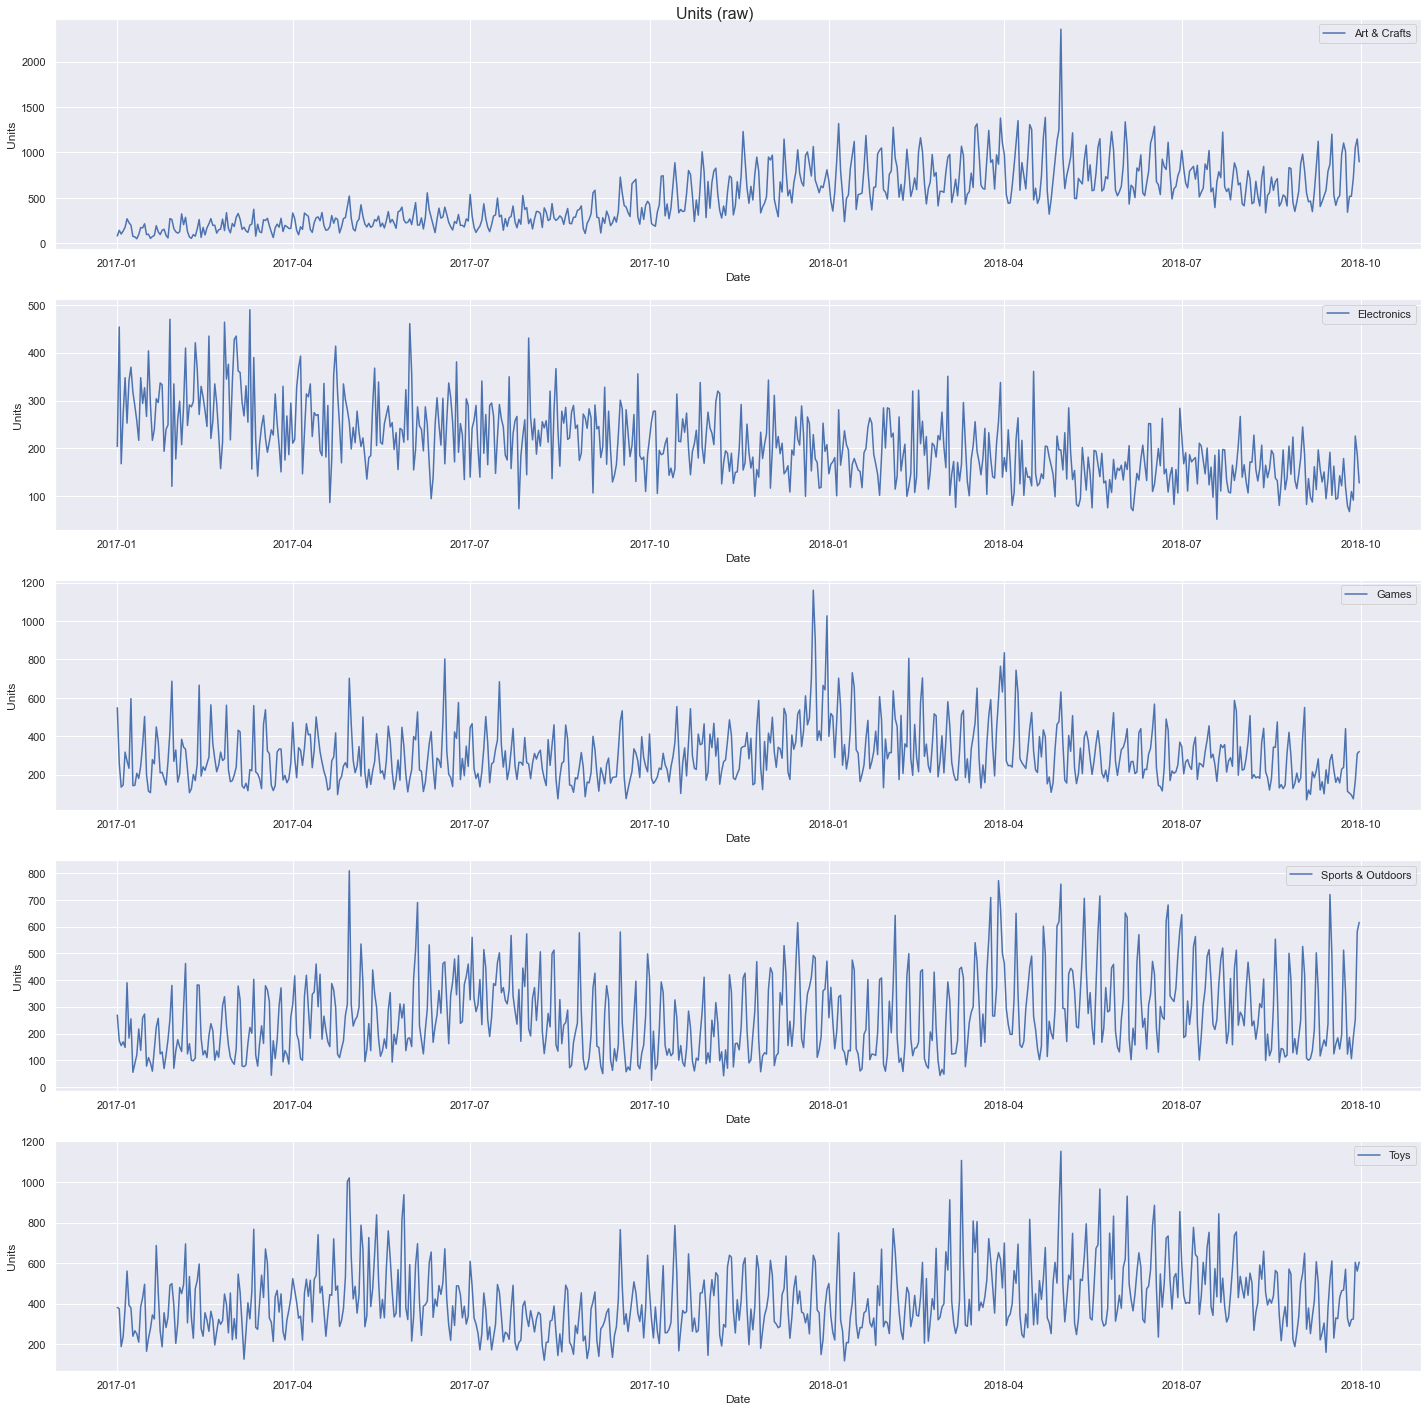

In [44]:
daily_category_units = daily_per_category.groupby(['Date', 'Product_Category'])['Units'].sum().reset_index()
fig, ax = plt.subplots(5, 1, figsize=(20,20))
for i, (label, group) in enumerate(daily_category_units.groupby('Product_Category')):
    sns.lineplot(data=group, x='Date', y='Units', ax=ax[i], label=label);
fig.suptitle("Units (raw)", fontsize=16);
fig.tight_layout()    

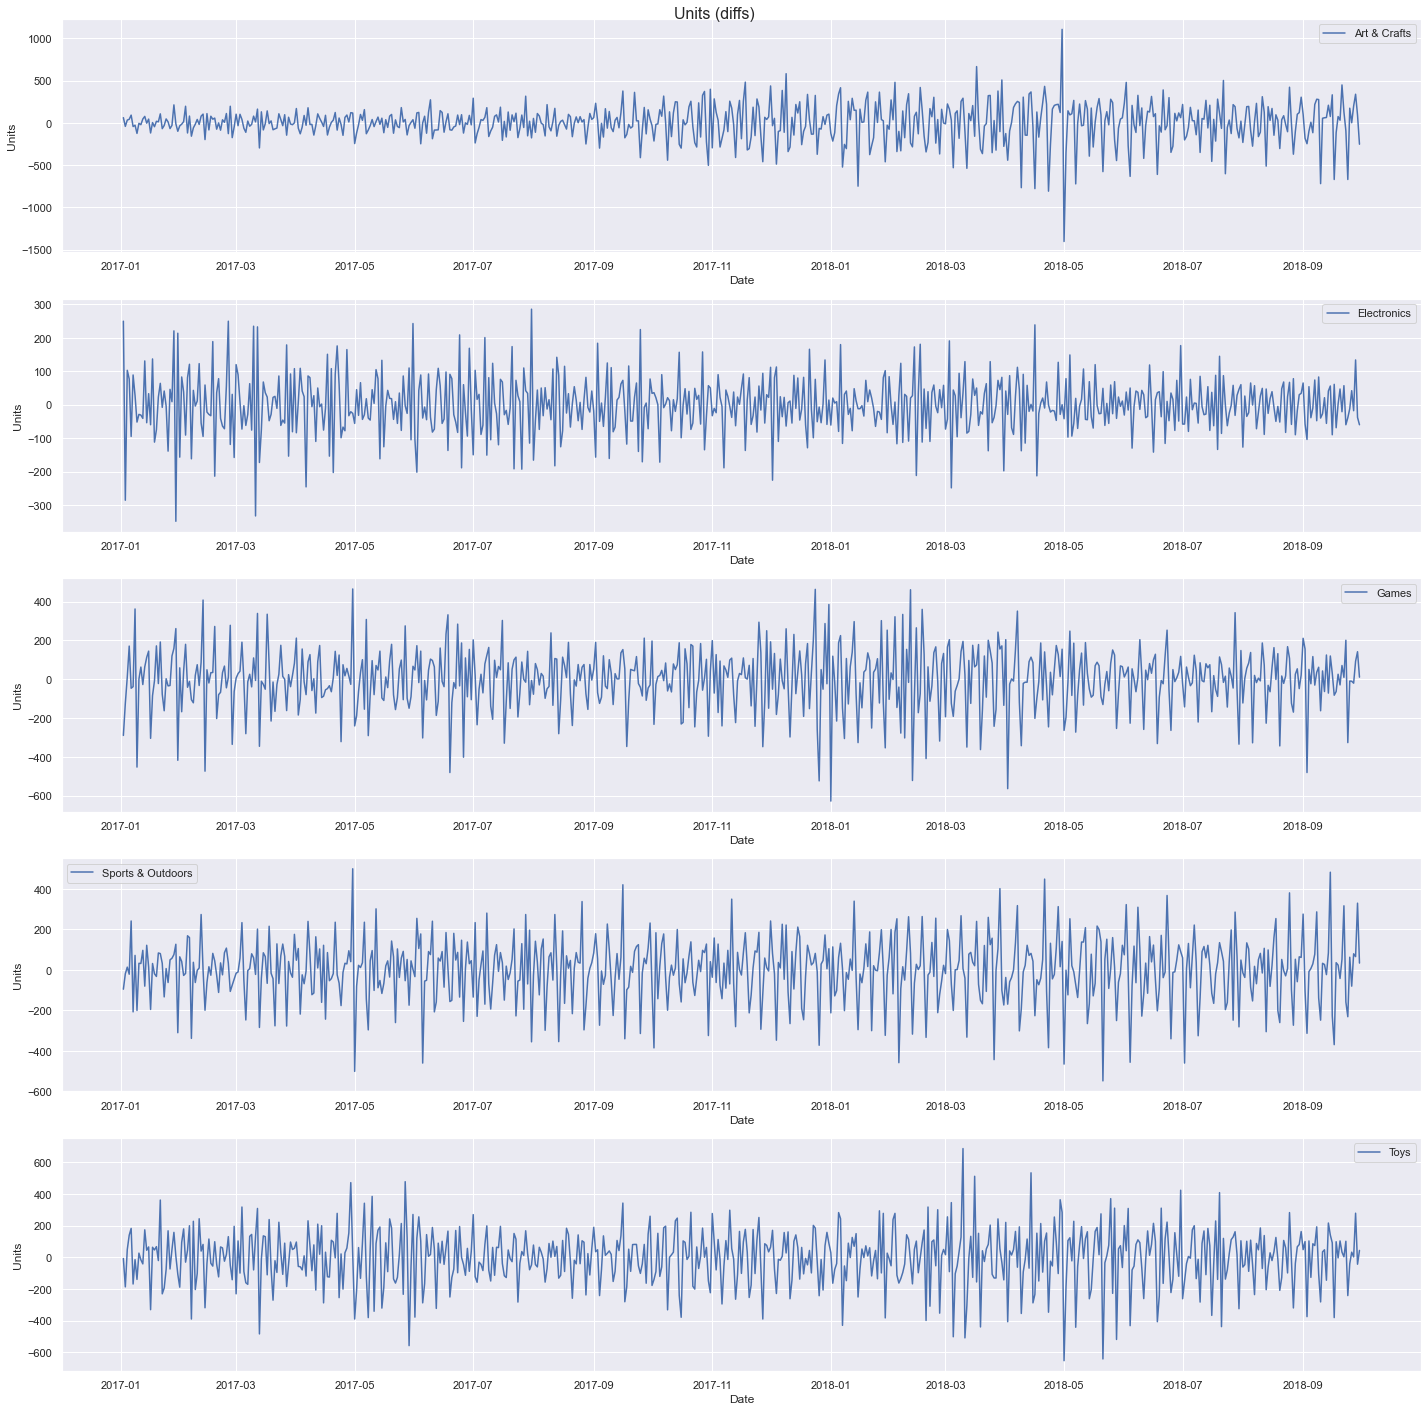

In [45]:
fig, ax = plt.subplots(5, 1, figsize=(20,20))
for i, (label, group) in enumerate(daily_category_units.groupby('Product_Category')):
    diffs = group['Units'].diff()
    sns.lineplot(x=group['Date'], y=diffs, ax=ax[i], label=label)
fig.suptitle("Units (diffs)", fontsize=16);
fig.tight_layout()    


### Statistical test for unit root.

In [46]:
from statsmodels.tsa.stattools import adfuller

# a = 0.05
adf_results = pd.DataFrame(index=daily_category_units['Product_Category'].unique(), columns=['adf', 'p_value', 'used_lag', 'is_stationary'])
for label, group in daily_category_units.groupby('Product_Category'):
    result = adfuller(group['Units'])
    adf_results.loc[label, :] = [result[0], result[1], result[2], result[1] < 0.05]
adf_results

adf   p_value used_lag is_stationary
Art & Crafts      -1.296351   0.63084       20         False
Electronics        -1.92159  0.321974       17         False
Games             -2.457415  0.126182       20         False
Sports & Outdoors -2.737408  0.067786       20         False
Toys              -2.091796  0.247826       20         False

None category is stationary

In [47]:
for label, group in daily_category_units.groupby('Product_Category'):
    result = adfuller(group['Units'].diff().dropna())
    adf_results.loc[label, :] = [result[0], result[1], result[2], result[1] < 0.05]
adf_results

adf p_value used_lag is_stationary
Art & Crafts      -10.552718     0.0       19          True
Electronics       -11.145243     0.0       16          True
Games              -8.884014     0.0       19          True
Sports & Outdoors  -7.648751     0.0       20          True
Toys               -9.327966     0.0       19          True

All category diffs are stationary.

### Seasonal decomposition for each category and their diffs.

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose

def plot_decompose(category):
    print(category)
    df = daily_category_units.loc[daily_category_units['Product_Category'] == category].set_index('Date')['Units']
    result = seasonal_decompose(df)
    result.plot();
    result = seasonal_decompose(df.diff().dropna())
    result.plot();


Art & Crafts


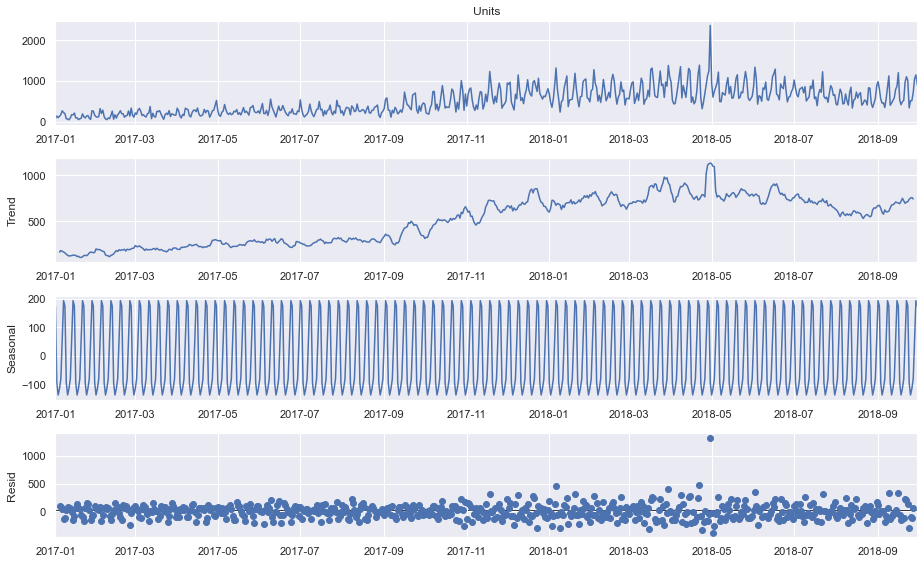

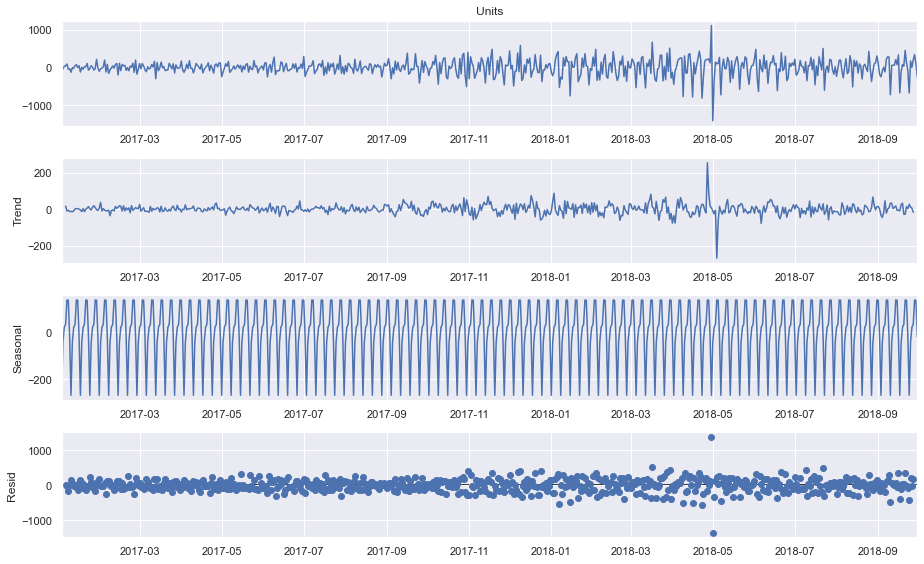

In [49]:
plot_decompose('Art & Crafts')

Electronics


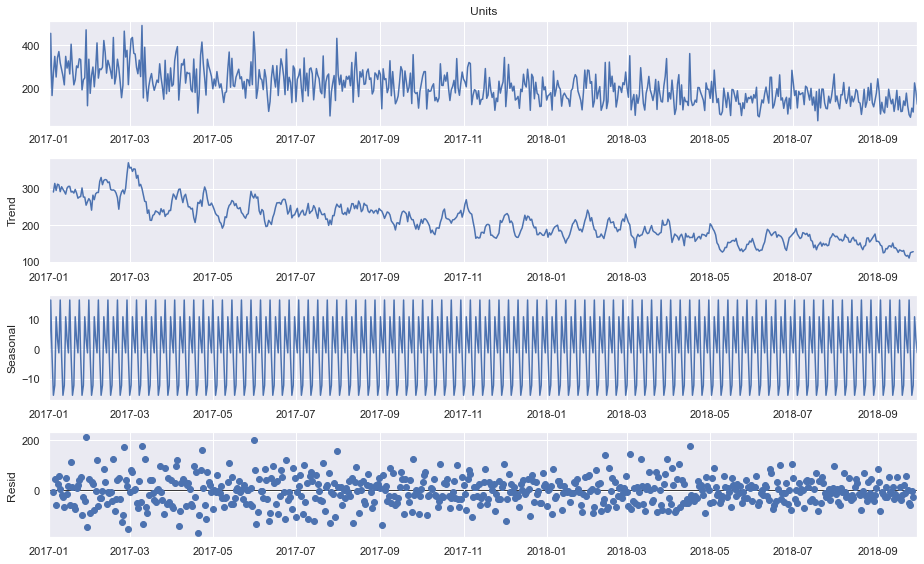

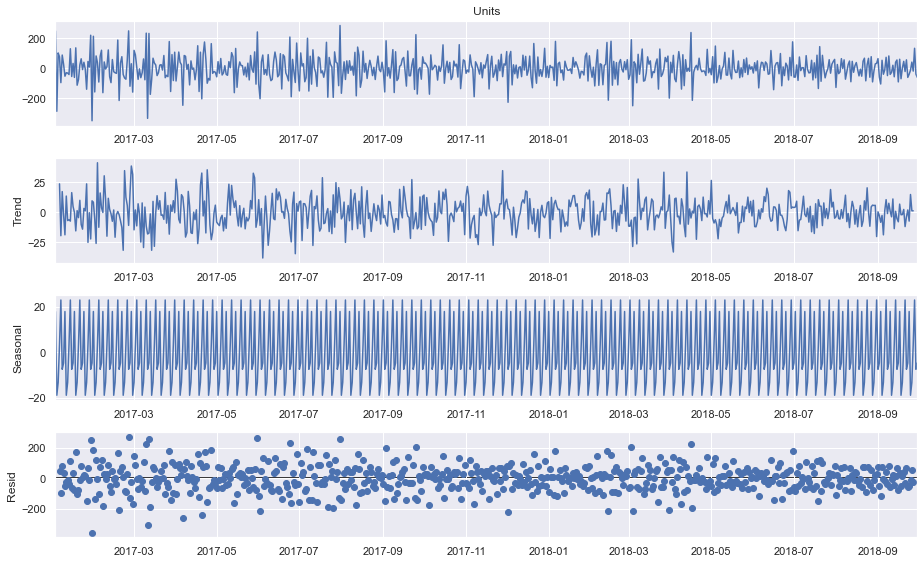

In [50]:
plot_decompose('Electronics')

Games


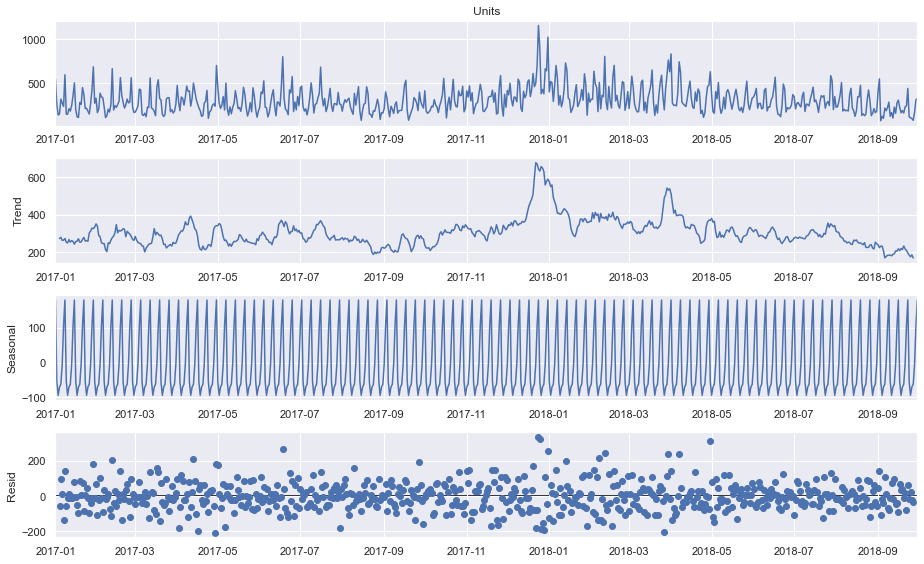

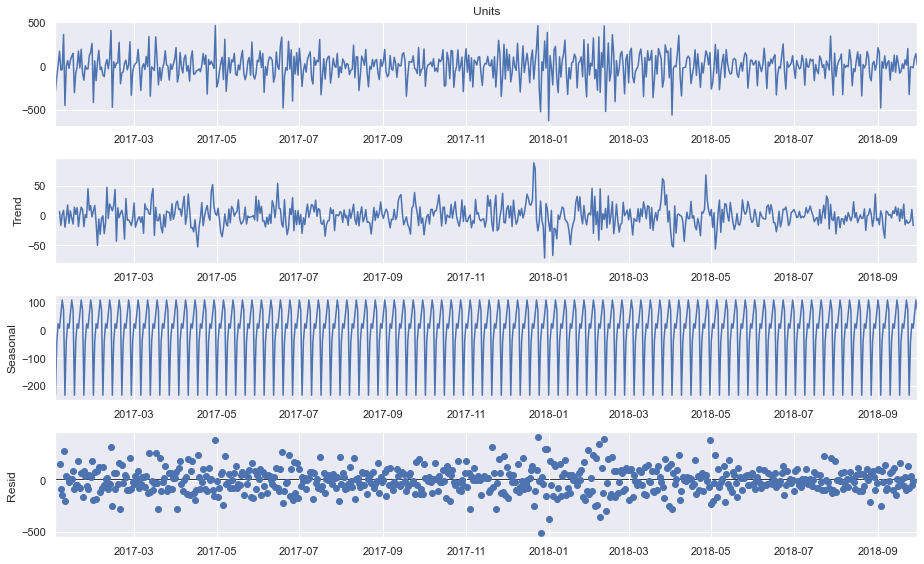

In [51]:
plot_decompose('Games')

Sports & Outdoors


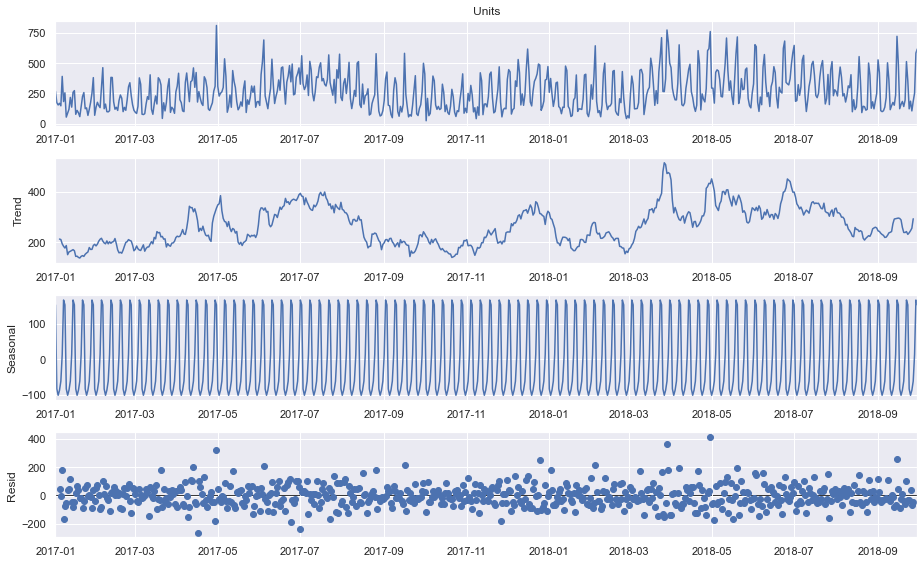

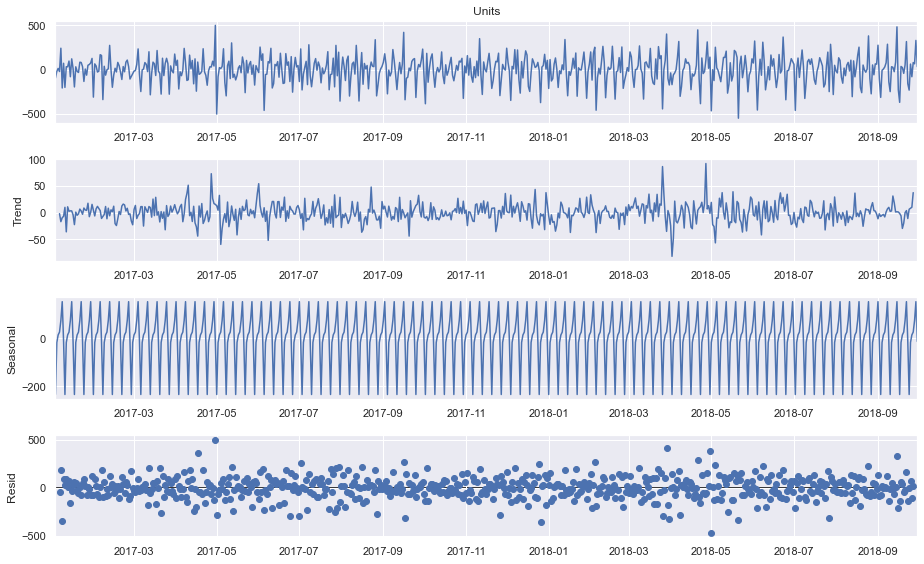

In [52]:
plot_decompose('Sports & Outdoors')

Toys


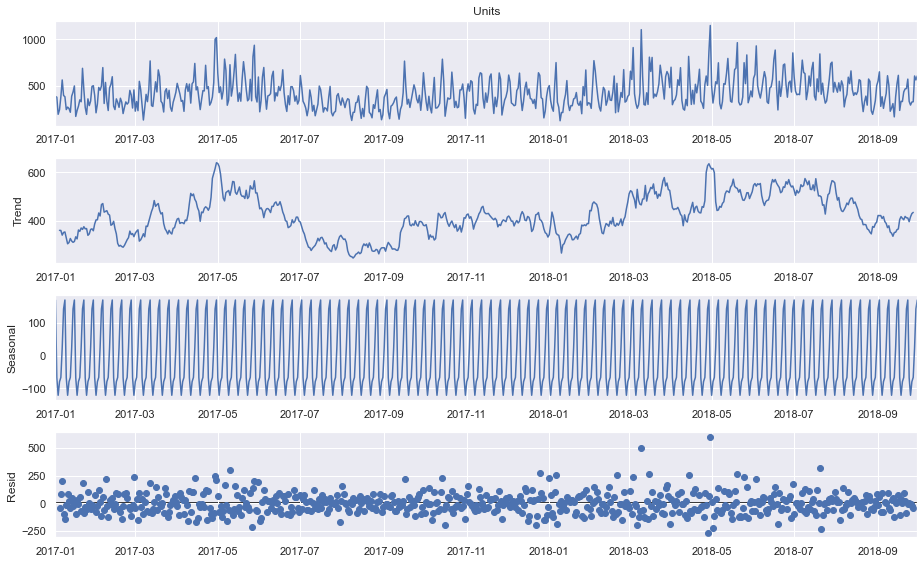

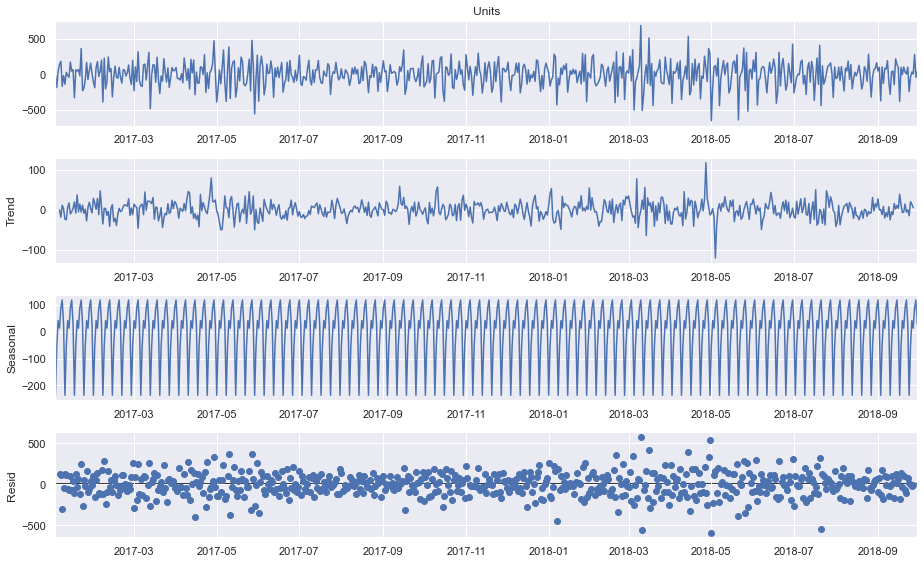

In [53]:
plot_decompose('Toys')

### ACF, PACF for each category and their diffs.

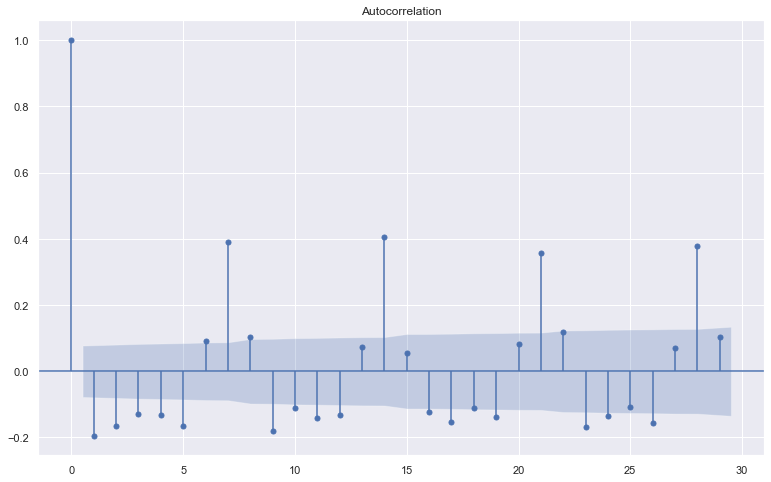

In [54]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
toys = daily_category_units.loc[daily_category_units['Product_Category'] == 'Toys'].set_index('Date')['Units'].diff().dropna()
toys.index.freq = '1D'
plot_acf(toys);

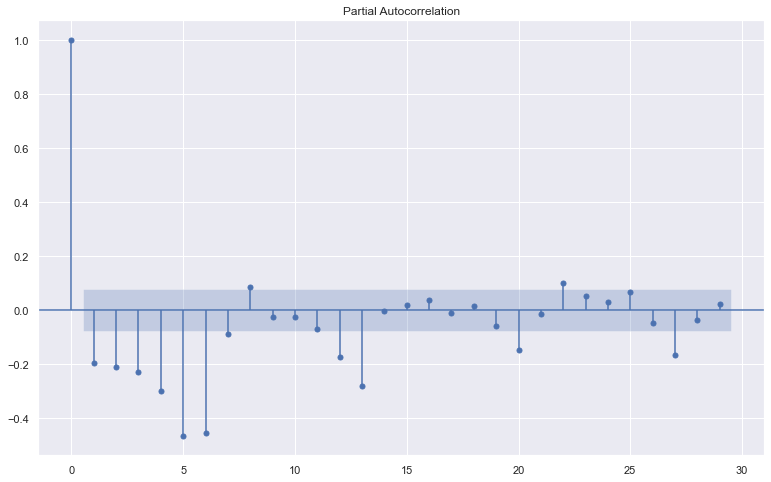

In [55]:
plot_pacf(toys);